In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
import scipy.optimize as opt

from util.expectiles import expectile, tauspace
from util.gmm import EXAMPLE

import tqdm.notebook as tqdm

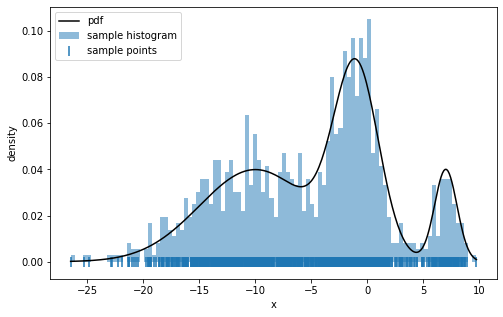

In [2]:
SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000, figsize=(8, 5))

In [5]:
def exp_smooth(x, y, newx=None, ω=1):
    """
    Given x, y(x), compute y^~(newx), smoothed version, with bandwidth ω
    """
    if newx is None: newx=x
    W = np.exp(-np.square(newx[:, np.newaxis] - x)/ω)
    W /= W.sum(axis=-1, keepdims=True)
    return W @ y

def polyfit(x, y, d, **kwargs):
    return np.polynomial.polynomial.Polynomial.fit(x, y, d, **kwargs)

def polyinv(p, y, tol=1e-6, domain=None):
    if np.isscalar(y):
        y = [y]
        n = 1
    else:
        n = len(y)
    x = np.zeros(n)
    for i in range(n):
        xi = (p - y[i]).roots()
        xi = xi[np.abs(xi.imag) < tol].real
        if domain:
            xi = xi[domain[0] < xi]
            xi = xi[xi < domain[1]]
        x[i] = xi[:1]
    return x


In [6]:
def setup_plot(sample=SAMPLE, x=GMM_X, f=GMM_Y):
    dx = x[1] - x[0]
    F = np.cumsum(f)*dx
    t = np.linspace(0.001, 0.999, 333)
    e = expectile(sample, t)
    g = np.gradient(e, t, edge_order=2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 8))
    ax[0,0].plot(e, t, color="black", alpha=0.5)
    ax[0,0].set_xlabel("expectile")
    ax[0,0].set_ylabel("asymmetry")
    ax[0,0].set_ylim([-0.1, 1.1])
    ax[0,1].plot(g, t, color="black", alpha=0.5)
    ax[0,1].set_xlabel("expectile derivative")
    ax[0,1].set_ylabel("asymmetry")
    ax[0,1].set_xscale('log')
    ax[0,1].set_ylim([-0.1, 1.1])
    ax[1,0].plot(x, F, color="black", alpha=0.5)
    ax[1,0].set_xlabel("x")
    ax[1,0].set_ylabel("F(x)")
    ax[1,0].set_ylim([-0.1, 1.1])
    ax[1,1].plot(x, f, color="black", alpha=0.5)
    ax[1,1].hist(sample, bins=100, alpha=0.2, density=True, color="black")
    ax[1,1].set_xlabel("x")
    ax[1,1].set_ylabel("f(x)")
    return ax

def experiment(τ, I, marker='.', **kwargs):
    ε = expectile(SAMPLE, τ)
    I.fit(ε, τ, **kwargs)
    X = I.sample(1000)
    ax = setup_plot()
    plt.gcf().suptitle(f"{τ.size}-tau {I}")
    ax[0,0].plot(ε, τ, marker=marker)
    ax[0,1].plot(I.g, I.τ, marker=marker)
    ax[1,0].plot(I.ε, I.F, marker=marker)
    ax[1,1].plot(I.ε, I.f, marker=marker)
    ax[1,1].hist(X, bins=100, alpha=0.2, density=True, color="purple")
    plt.show()

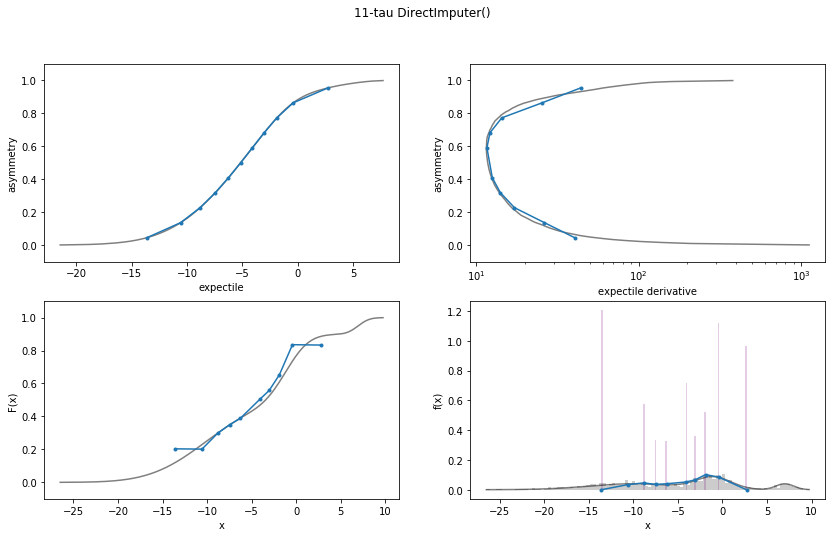

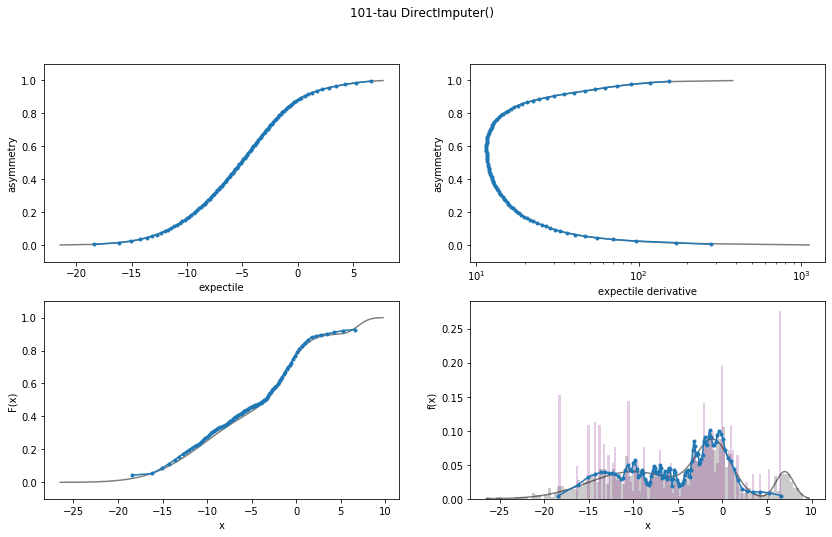

In [164]:
class DirectImputer:
    def fit(self, ε_, τ_):
        g_ = np.gradient(ε_, τ_, edge_order=2)
        i = ε_.size//2
        self.μ = μ = ε_[i]
        self.ε = ε = np.delete(ε_, i)
        self.τ = τ = np.delete(τ_, i)
        self.g = g = np.delete(g_, i)
        self.N = N = -(ε - μ + τ * g * (1-2*τ))
        self.D = D = g * (1-2*τ)**2
        self.F = F = N / D
        self.f = np.gradient(F, ε, edge_order=1)
        return self
    def sample(self, k):
        y = np.random.random(k)
        i = np.searchsorted(self.F, y)
        x = self.ε[np.clip(i, 0, self.ε.size-1)]
        return x
    def __repr__(self):
        return f"DirectImputer()"

experiment(tauspace(11),  DirectImputer())
experiment(tauspace(101), DirectImputer())

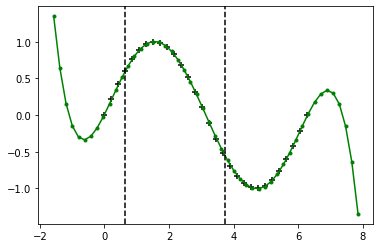

In [57]:
x = np.linspace(0, 2*np.pi, 30)
y = np.sin(x)
p = polyfit(x, y, d=5)
plt.scatter(x, y, marker="+", color="black")
x_ = np.linspace(-0.5*np.pi, 2.5*np.pi, 50)
plt.plot(x_, p(x_), marker='.', color='green')
xh = polyinv(p, [0.6, -0.55], domain=[0, 2*np.pi])
for xhi in xh:
    plt.axvline(xhi, color='black', linestyle='--')
plt.show()

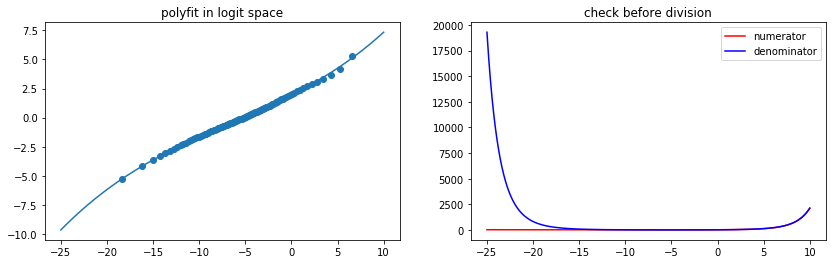

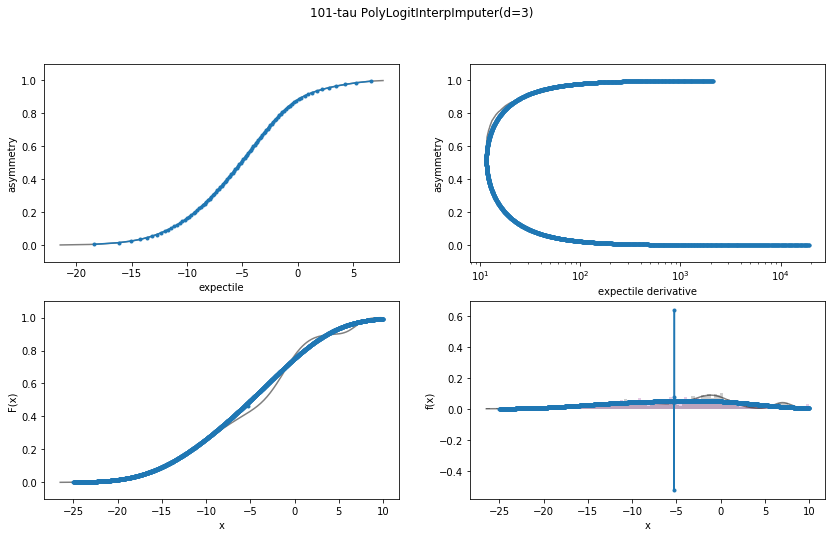

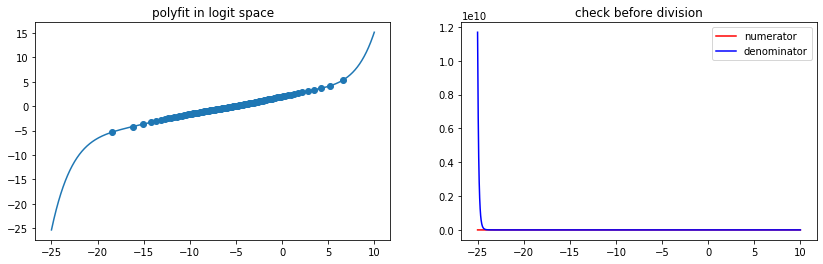

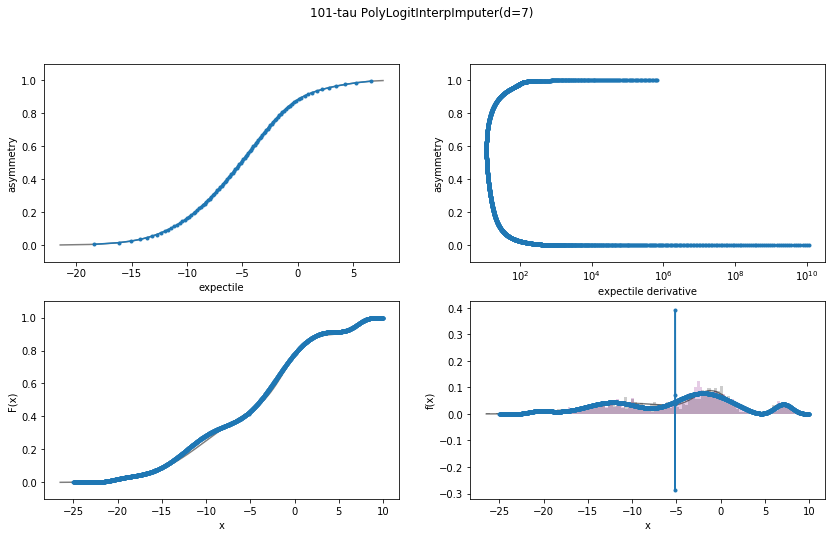

In [58]:
class PolyLogitInterpImputer:
    def __init__(self, x=np.linspace(-25, 10, 2000), degree=3, verbose=False):
        self.degree = degree
        self.x = x
        self.verbose = verbose
    def fit(self, ε_, τ_):
        self.ε_ = ε_
        self.τ_ = τ_
        self.ε = ε = x = self.x
        self.p = p = polyfit(ε_, sc.logit(τ_), self.degree)
        self.μ = μ = polyinv(p, sc.logit(0.5))
        self.τ = τ = sc.expit(p(ε))
        self.g = g = np.gradient(ε, τ, edge_order=2)
        self.N = N = -(ε - μ + τ*g*(1-2*τ))
        self.D = D = g * (1-2*τ)**2
        self.F = F = N / D
        self.f = f = np.gradient(F, ε, edge_order=1)
        if self.verbose:
            fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 4))
            ax0.scatter(ε_, sc.logit(τ_))
            ax0.plot(x, p(x))
            ax0.set_title("polyfit in logit space")
            ax1.plot(ε, N, color="red",  label="numerator")
            ax1.plot(ε, D, color="blue", label="denominator")
            ax1.legend()
            ax1.set_title("check before division")
            plt.show()
        return self
    def sample(self, k):
        y = np.random.random(k)
        i = np.searchsorted(self.F, y)
        x = self.ε[np.clip(i, 0, self.ε.size-1)]
        return x
    def __repr__(self):
        return f"PolyLogitInterpImputer(d={self.degree})"

experiment(tauspace(101), PolyLogitInterpImputer(degree=3, verbose=True))
experiment(tauspace(101), PolyLogitInterpImputer(degree=7, verbose=True))

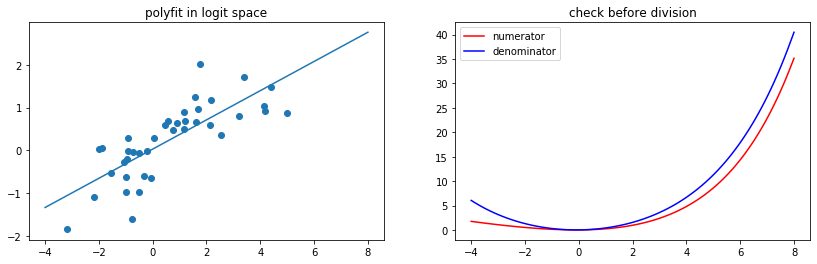

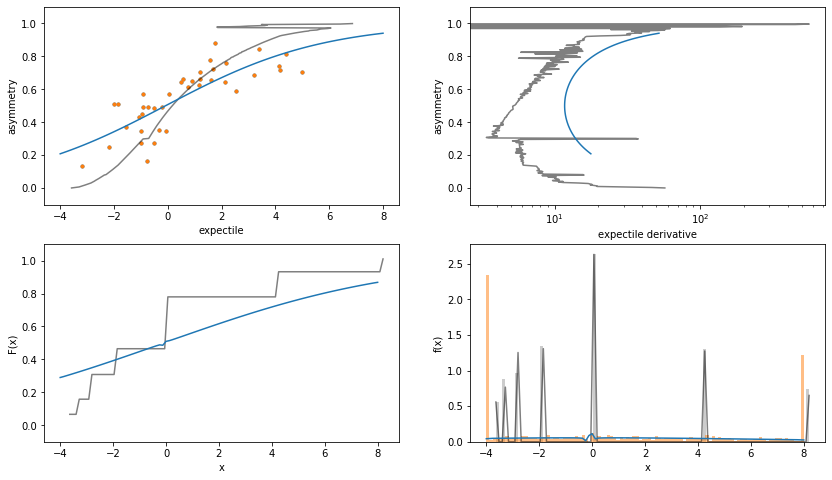

In [63]:
# DEEPMIND DATA DUMP (variables renamed, comments added)
# juice volumes in micro-litres
juice_vols = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])
# juice volumes in estimated utility space
juice_utils = np.array([-3.63887402657031,-3.31870708722146,  -2.84609534101164,
                        -1.86975535870141, 0.0350553672638314, 4.18830501181676,
                         8.20381872775166])
# juice empirical probabilities
juice_probs = np.array([0.06612594, 0.09090909, 0.14847358, 0.15489467,
                       0.31159175, 0.1509519 , 0.07705306])
# estimated neural asymmetries (neural taus)
neural_asyms = np.array([0.665148134736891,0.65208410906952,0.613744203780139,
                         0.775212700883808,0.707915816841008,0.570103354233973,
                         0.882127332095316,0.508575044586604,0.486016624470385,
                         0.490519368353783,0.353180140687647,0.34502602367731,
                         0.274459190431141,0.624608202330519,0.511245599898681,
                         0.275963695780172,0.574282416537853,0.494461077846514,
                         0.249573167763381,#1.01616027303818,
                         0.136555552978056,
                         0.716127024137563,0.658310695222273,0.493856204792549,
                         0.815972879462343,0.433624365681467,0.643716612535732,
                         0.724905499014785,0.3681787227383,  0.705733696238299,
                         0.76246447053036, 0.739327730375869,0.590831434674471,
                         0.346659782367775,0.449000983609862,0.662902110431635,
                         0.645905621173483,0.16704746815482, 0.846125077182948,
                         0.689060956288534])
neural_asyms = np.clip(neural_asyms, 0., 1.)
# estimated neural expectile values (neural reversal points) in utility space
neural_expts = np.array([ 1.19796718528621,  0.909588860368442,  0.768290210301997,
                          1.5580695804582,   1.18069340075516,  -0.917277009040899,
                          1.76606208326366, -1.99990282124502,  -0.52508567014901,
                         -0.72677865537825, -0.317750664489987, -0.0555191676477702,
                         -0.498294836948614, 1.16799418233059,  -1.86969915298433,
                         -0.980841264017123, 0.0346564269295749,-0.917418194178877,
                         -2.19520456394411,  #8.10381872775166, 
                         -3.18979437039029,
                          4.18823808094621,  1.59258444073823,  -0.210742609830699,
                          4.38901915501838, -1.0533487207759,    0.472919232719837,
                          1.69636515581653, -1.55263442315208,   4.99096579152878,
                          2.16489750392618,  4.1202653189854,    2.53839455360929,
                         -0.981001892834966,-0.967509962517738,  0.554271248178451,
                          2.11181823971785, -0.766921663162386,  3.38445321759506,
                          3.21931839438752])
# END DEEPMIND DATA DUMP

# i'm going to need these to be sorted according to the taus
order = np.argsort(neural_expts)
neural_asyms = neural_asyms[order]
neural_expts = neural_expts[order]

# and i'm going to need a sample
neural_sample = np.random.choice(juice_utils, p=juice_probs, size=1000)
neural_x_range = [neural_sample.min(), neural_sample.max()]
neural_x_res = 100
neural_x = np.linspace(*neural_x_range, neural_x_res)
neural_dx = np.diff(neural_x_range) / neural_x_res
neural_fx = np.zeros_like(neural_x)
neural_fx[np.searchsorted(neural_x, juice_utils)] = juice_probs / neural_dx
neural_Fx = neural_fx.cumsum()*neural_dx

# now time to fit and plot
smooth_expts = False
smooth_asyms = False
neural_expts_used = exp_smooth(neural_asyms, neural_expts, ω=1/20) if smooth_expts else neural_expts
neural_asyms_used = exp_smooth(neural_expts, neural_asyms, ω=1/5 ) if smooth_asyms else neural_asyms
I = PolyLogitInterpImputer(x=np.linspace(-4, 8, 100), degree=1, verbose=True).fit(neural_expts_used, neural_asyms_used)

# play with smoothing
ax = setup_plot(neural_sample, neural_x, neural_fx)
ax[0,0].scatter(neural_expts, neural_asyms, marker='.')
ax[0,0].scatter(neural_expts_used, neural_asyms_used, marker='.')
ax[0,0].plot(I.ε, I.τ)
ax[0,1].plot(I.g, I.τ)
ax[1,0].plot(I.ε, I.F)
ax[1,1].plot(I.ε, I.f)
ax[1,1].hist(I.sample(1000), bins=100, alpha=0.5, density=True)
plt.show()

### Notes

* Polyfit method becomes limited by degree rather than by number of expectiles, beyond a certain point. In fact I guess you could probably show that it has finitely limited ability to recognise multimodality (e.g. linear fit --> you will recover a unimodal distribution).
    * Indeed, fitting to 11 doesn't really change the (limited) reovery of the CDF.
    * The shift to the num and denom is probably not really a good idea...? could I merge the provided e and the extrapolated xs, and would that help?
* Direct method has good resolution in the inner part of the distribution (assuming not too noisy), but still clearly fails at the boundaries.
    * Could I combine these two methods, for polynomial extrapolation but direct potentially combine the two methods to get the good internal resolution but also the sensible extrapolation?

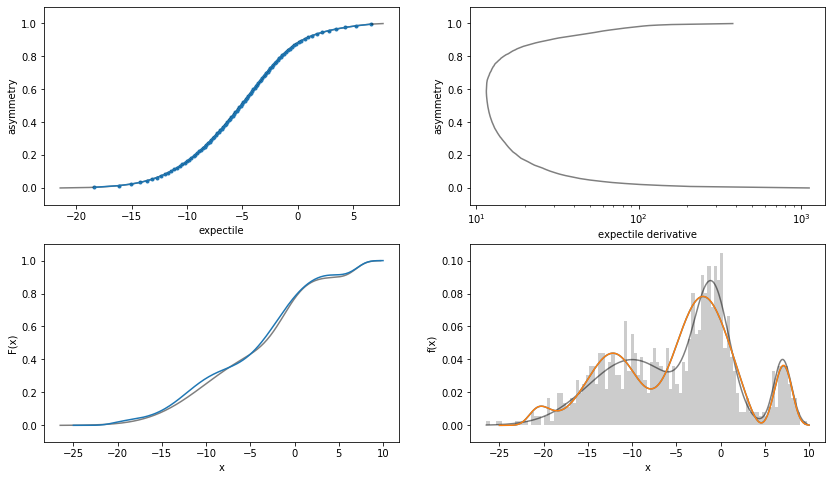

In [8]:
class PolyLogitImputer:
    def __init__(self, degree=3):
        self.degree = degree
    def F(self, x):
        μ   = self.μ        # ε(0.5)
        px  = self.p(x)     # p(x)
        dpx = self.dp(x)    # p'(x)
        spx = sc.expit(px)  # σ(p(x))
        tpx = (1-2*spx)     # tanh(p(x)) = 1-2σ(p(x))
        return -spx/tpx*(1 + (x-μ)*(1-spx)*dpx/tpx)
    def f(self, x):
        xμ   = x - self.μ         # x - μ
        px   = self.p(x)          # p(x)
        dpx  = self.dp(x)         # p'(x)
        ddpx = self.ddp(x)        # p''(x)
        sx   = sc.expit(px)       # τ(x) = σ(p(x))
        tx   = (1-2*sx)           # 1-2τ(x) = tanh(p(x))
        dsx  = sx*(1-sx)*dpx      # τ'(x) = σ(p(x))(1-σ(p(x)))p'(x)
        fx = -dsx*(xμ*dpx*tx + xμ*ddpx/dpx + 2 + 4*xμ*dsx/tx)/(tx**2)
        return fx
    def τ(self, x):
        return sc.expit(self.p(x))
    def ε(self, y):
        return polyinv(self.p, sc.logit(y))
    def fit(self, ε_, τ_):
        self.ε_  = ε_
        self.τ_  = τ_
        self.p   = polyfit(ε_, sc.logit(τ_), self.degree)
        self.dp  = self.p.deriv()
        self.ddp = self.dp.deriv()
        self.μ   = polyinv(self.p, sc.logit(0.5))
        return self
    def sample(self, k):
        y = np.random.random(k)
        x = opt.root(lambda x: y-self.F(x), x0=np.zeros(k)).x
        return x
    def __repr__(self):
        return f"PolyLogitImputer(d={self.degree})"

τ = tauspace(101)
ε = expectile(SAMPLE, τ)
I = PolyLogitImputer(degree=7).fit(ε, τ)
x = np.linspace(-25, 10, 200)
ax = setup_plot()
ax[0,0].scatter(ε, τ, marker='.')
ax[0,0].plot(ε, I.τ(ε))
# ...
ax[1,0].plot(x, I.F(x))
ax[1,1].plot(x, np.gradient(I.F(x), x))
ax[1,1].plot(x, I.f(x))
# ax[1,1].hist(I.sample(200), bins=100, alpha=0.2, density=True, color="purple")
ax[1,1].set_ylim([-0.01, 0.11])
plt.show()
# print(I.sample(101))

In [20]:
τ = tauspace(101)
ε = expectile(SAMPLE, τ)
I = PolyLogitImputer(degree=7).fit(ε, τ)

from scipy import sparse as sp

def time(k, bs=100):
    print(f"{k=}, {bs=}")
    y = np.random.random(k)
#     print("solve k*root_scalar")
#     %timeit np.array([opt.root_scalar(lambda x: I.F(x)[0]-yi, x0=0, x1=1).root for yi in y])
#     print("solve 1*root (vector)")
#     %timeit opt.root(lambda x: I.F(x)-y, x0=np.zeros(k)).x
#     print("solve 1*root (vector) + diagonal jacobian provided")
#     %timeit opt.root(lambda x: I.F(x)-y, jac=lambda x: np.diag(I.f(x)), x0=np.zeros(k)).x
    print("solve k//bs*root (vector) + diagonal jacobian provided")
    %timeit np.concatenate([opt.root(lambda x: I.F(x)-b, jac=lambda x: np.diag(I.f(x)), x0=np.zeros_like(b)).x for b in [y[i:i+bs+1] for i in range(0, k, bs)]])

time(1000, bs=90)
time(1000, bs=100)
time(1000, bs=110)

k=1000, bs=90
solve k//bs*root (vector) + diagonal jacobian provided
114 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
k=1000, bs=100
solve k//bs*root (vector) + diagonal jacobian provided
113 ms ± 723 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
k=1000, bs=110
solve k//bs*root (vector) + diagonal jacobian provided
131 ms ± 8.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<ipython-input-78-ed535a95b27c>:8: RuntimeWarning: divide by zero encountered in true_divide
  x[i] = x[i] - y[i]/J(x[i])
<ipython-input-78-ed535a95b27c>:13: RuntimeWarning: invalid value encountered in greater
  i = (np.abs(y) > tol)


False


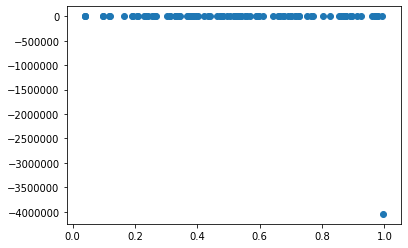

In [78]:
def vectorised_diagonal_root_nm(f, x, J, dom=[-100, 100], tol=1e-5):
    lo, hi = dom
    x = x.copy()
    y = f(x)
    i = (np.abs(y) > tol)
    t = 0
    while np.any(i):
        x[i] = x[i] - y[i]/J(x[i])
        t += 1
        if t > 100:
            raise Exception("Convergence error.")
        y[i] = f(x)[i]
        i = (np.abs(y) > tol)
#         i &= (x > lo) & (x < hi)
    print(np.any(np.isnan(x)))
    return x

y = np.random.random(100)
x = vectorised_diagonal_root_nm(lambda x: I.F(x)-y, J=lambda x: I.f(x), x=np.zeros_like(y))
plt.scatter(y, x)
plt.show()


# def time2(k, bs=100):
#     print(f"{k=}, {bs=}")
#     y = np.random.random(k)
    
#     print("solve k//bs*root (my nm) + diagonal jacobian provided")
#     %timeit vectorised_diagonal_root_nm(lambda x: I.F(x)-y, J=lambda x: I.f(x), x=np.zeros_like(y))

#     print("solve k//bs*root (vector) + diagonal jacobian provided")
#     %timeit np.concatenate([opt.root(lambda x: I.F(x)-b, jac=lambda x: np.diag(I.f(x)), x0=np.zeros_like(b)).x for b in [y[i:i+bs+1] for i in range(0, k, bs)]])
    
# time2(1000)

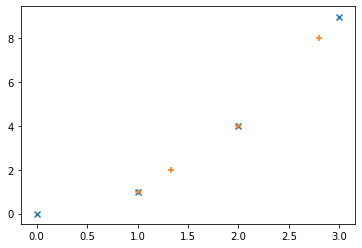

In [4]:
def invert(x0, y0, y):
    """
    Return x in (increasing) x0 corresponding to y in (increasing) y0
    using linear interpolation (or nan for out-of-range values)
    """
    n = len(y0)
    x = np.zeros_like(y, dtype=float)
    i = np.searchsorted(y0, y)
    out = (i == 0) | (i == n)

    ok = ~out
    i = i[ok]
    y_lo = y0[i-1]
    y_hi = y0[i]
    x_lo = x0[i-1]
    x_hi = x0[i]
    t = (y[ok] - y_lo)/(y_hi - y_lo)
    x[out] = np.nan
    x[ok] = (1-t)*x_lo + t*x_hi
    return x

xs = np.arange(4)
ys = xs**2
y = np.array([-1, 1, 2, 4, 8, 10])
x = invert(xs, ys, y)
plt.scatter(xs, ys, marker='x')
plt.scatter(x, y, marker='+')
plt.show()

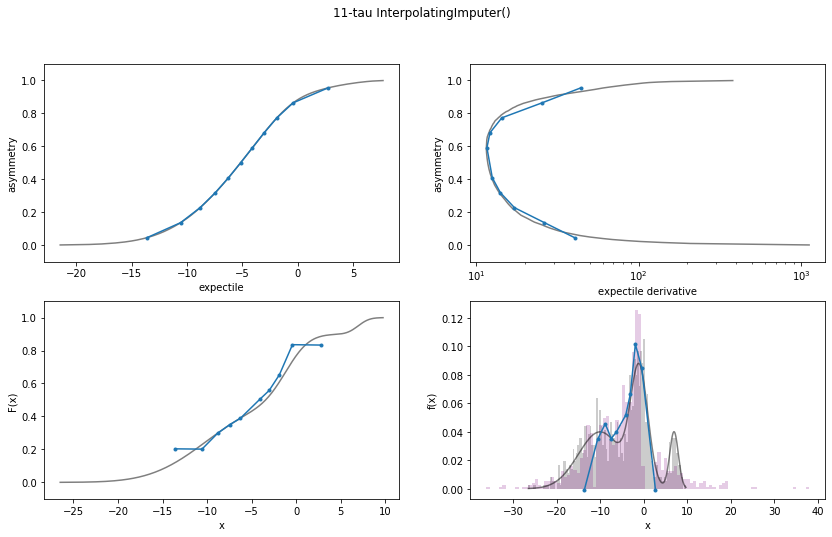

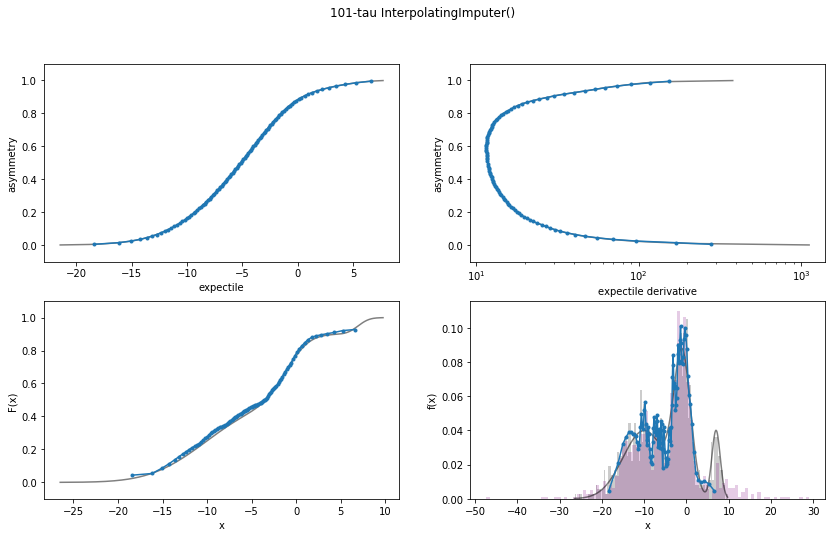

In [7]:
class InterpolatingImputer:
    def fit(self, ε_, τ_, verbose=False, i=None):
        self.verbose = verbose
        # find CDF for interpolation
        g_ = np.gradient(ε_, τ_, edge_order=2)
        if i is None: i = ε_.size//2
        self.μ = μ = ε_[i]
        self.ε = ε = np.delete(ε_, i)
        self.τ = τ = np.delete(τ_, i)
        self.g = g = np.delete(g_, i)
        self.N = N = -(ε - μ + τ * g * (1-2*τ))
        self.D = D = g * (1-2*τ)**2
        self.F = F = N / D
        self.f = np.gradient(F, ε, edge_order=1)
        # then a linear fit for extrapolation
        self.p = polyfit(ε, sc.logit(F), 1, domain=[-1,1],window=[-1,1])
        self.b, self.a = self.p
        if self.verbose:
            x = np.linspace(-25, 10, 100)
            plt.scatter(ε, F)
            plt.plot(x, sc.expit(self.a*x+self.b))
        return self
    def F_inv(self, y):
        x = invert(self.ε, self.F, y)
        out = np.isnan(x)
        x[out] = (sc.logit(y[out])-self.b)/self.a
        if self.verbose:
            plt.scatter(x[~out], y[~out], marker=".")
            plt.scatter(x[out], y[out], marker="x")
            plt.show()
        return x
    def sample(self, k):
        y = np.random.random(k)
        x = self.F_inv(y)
        return x
    def __repr__(self):
        return f"InterpolatingImputer()"

experiment(tauspace(11), InterpolatingImputer())
experiment(tauspace(101), InterpolatingImputer())